In [1]:
# Importing mandatory libraries
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Dropout,Concatenate,Input,BatchNormalization
import tensorflow as tf
import tensorflow.keras as k
import h5py as hd
import numpy as np
import matplotlib.pyplot as plt
from keras.regularizers import l2
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import os
import cv2

In [2]:
# Declaring paths for the training images
annt = '/content/drive/MyDrive/MINeD/annt_img'
ori = '/content/drive/MyDrive/MINeD/images/itba'

In [3]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Listing contents of the directories
annt_imgs = os.listdir(annt)
ori_imgs = os.listdir(ori)

In [5]:
# Storing the annotated images in a dictionary
di = {}
for i in annt_imgs:
  ind = i[:i.index('.')]
  di[ind] = [i] 

In [6]:
# Pairing annotated images with their original images
for i in ori_imgs:
  ind = i[:i.index('.')]
  di[ind].append(i) 

In [7]:
# Pre-processing the data
ori_arr_0 = []
annt_arr_0 = []
for i in di:
  
  ori_im = cv2.imread(os.path.join(ori,di[i][1]))
  ori_im = cv2.cvtColor(ori_im,cv2.COLOR_BGR2RGB)

  im0 = cv2.resize(ori_im,(640,192))
  ori_arr_0.append(im0)

  annt_im = cv2.imread(os.path.join(annt,di[i][0]),cv2.IMREAD_GRAYSCALE)
  im0 = cv2.resize(annt_im,(640,192))
  annt_arr_0.append(im0)
  

In [8]:
# Contrasting images for display
img = annt_arr_0[1]
cls0 = np.where(img==0)
cls1 = np.where(img==1)
cls2 = np.where(img==2)
new = np.zeros((img.shape[0],img.shape[1]))
new[cls1[0],cls1[1]] = 255

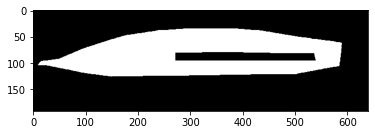

In [9]:
# Displaying the image
plt.imshow(new,cmap='gray')

In [10]:
# Declaring the source path
src = '/content/drive/MyDrive/MINeD'

In [11]:
# Converting images to numpy array
ori_arr_0_nd = np.array(ori_arr_0) 
annt_arr_0_nd = np.array(annt_arr_0)

In [12]:
# Creating the dataset
try:
    hf = hd.File(os.path.join(src,'train_0.h5'),'w')
    hf.create_dataset('ori',data=np.array(ori_arr_0_nd))
    hf.create_dataset('annt',data=np.array(annt_arr_0_nd))
finally:
    hf.close()

In [13]:
# Loading the dataset
try:
    hf = hd.File(os.path.join(src,'train_0.h5'),'r')
    img_ori_0 = np.array(hf.get('ori'))
    img_annt_0 = np.array(hf.get('annt'))
finally:
    hf.close()

In [14]:
# One-hot encoding the images
img_annt_0 = tf.keras.utils.to_categorical(img_annt_0)

In [17]:
# SegNet Model architecture
def segnet(pretrained_weights = None,input_size = (192,640,3),classes=3):
    inputs = Input(input_size)
    #step1
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1=BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1=BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    #step2
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2=BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2=BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    #step3
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3=BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3=BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3=BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    #step4
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4=BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4=BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4=BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    #step5
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5=BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5=BatchNormalization()(conv5)
    conv5=BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5=BatchNormalization()(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    #step6
    up6 = Conv2D(1024, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pool5))
    merge6 = concatenate([conv5,up6], axis = 3)
    conv6 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6=BatchNormalization()(conv6)
    conv6 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6=BatchNormalization()(conv6)
    
    #step7
    up7 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv4,up7], axis = 3)
    conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7=BatchNormalization()(conv7)
    conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7=BatchNormalization()(conv7)
    
    #step8
    up8 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv3,up8], axis = 3)
    conv8 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8=BatchNormalization()(conv8)
    conv8 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8=BatchNormalization()(conv8)

    #step9
    up9 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv2,up9], axis = 3)
    conv9 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9=BatchNormalization()(conv9)
    conv9 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9=BatchNormalization()(conv9)
    
    #step10   
    up10 = Conv2D(64,3,activation='relu',padding='same',kernel_initializer = 'he_normal')(UpSampling2D(size=(2,2))(conv9))
    merge10 = concatenate([conv1,up10],axis=3)
    conv10 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10)
    conv10=BatchNormalization()(conv10)
    conv10 = Conv2D(classes, 1, activation = 'softmax')(conv10)

    model = Model(inputs,conv10)
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt,
             loss="categorical_crossentropy",
             metrics=["accuracy"])    
    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [18]:
tf.keras.backend.clear_session()

In [19]:
# Creating instance of SegNet Model
model = segnet()

In [ ]:
# Training the model
model.fit(x=img_ori_0/255.0,y=img_annt_0,batch_size=3,epochs=20,validation_split=0.2)

In [31]:
# Predicting the output
preds = model.predict(img_ori_0[0].reshape((-1,192,640,3))/255)